# Imports

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import keras

2025-02-01 16:24:11.759670: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-01 16:24:11.925375: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
import torchvision
import torchvision.transforms as transforms
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader


# Load dataset

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(root='../fashion_mnist', train=True, download=False, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='../fashion_mnist', train=False, download=False, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

In [4]:
import utils


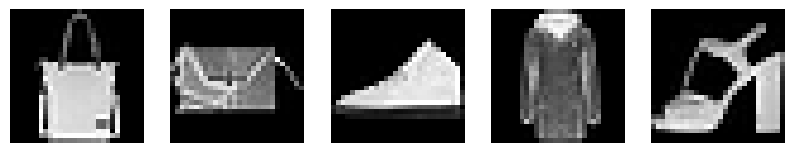

In [5]:
utils.show_images(train_set)

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


NameError: name 'tf' is not defined

In [44]:
os.getcwd()

NameError: name 'os' is not defined

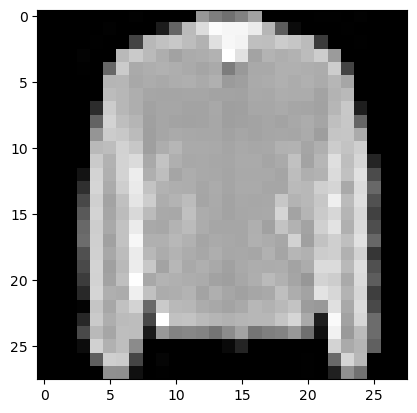

In [11]:
random_index = np.random.randint(0, len(x_train))
plt.imshow(x_train[random_index]/255.0, cmap='gray')

Let's apply transformations on some data

In [14]:
import augmentation_transforms as at

In [33]:
transformed_img = at.random_flip(x_train[0])

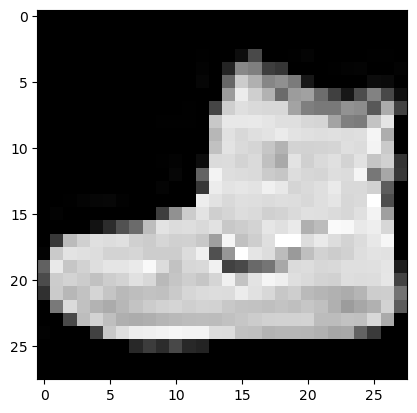

In [35]:
plt.imshow(transformed_img, cmap='gray')

# Définition de l'agent LSTM

Ce LSTM prend en entrée un vecteur aléatoire et génère une politique d'augmentation.

Ce LSTM génère une politique d'augmentation sous forme de 5 nombres entre 0 et 1.

In [6]:
torch.cuda.is_available()

False

In [7]:
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class AutoAugmentLSTM(nn.Module):
    def __init__(self, input_size=10, hidden_size=128, num_layers=2, output_size=5):
        super(AutoAugmentLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # 5 valeurs pour 5 types d'augmentation

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Dernière sortie de la séquence
        return torch.sigmoid(out)  # Convertir en probabilités entre 0 et 1

lstm = AutoAugmentLSTM().to(device)


# Génération des Politiques d’Augmentation

On convertit la sortie du LSTM en transformations dynamiques.

Seules certaines transformations sont appliquées selon la politique générée.

In [8]:
import random

def apply_augmentations(image, 
                        policy, 
                        replace : bool # this argument is used to specify if the data should be replaced by the augmented data or enriched.
                        ):
    augmentations = [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.GaussianBlur(kernel_size=3)
    ]

    for i, aug in enumerate(augmentations):
        if policy[i] > 0.5:  # Seuil pour activer une transformation
            image_aug = aug(image)
    if replace : 
        return image_aug
    else : 
        return image, image_aug


# Modèle Proxy pour Tester les Augmentations

On entraîne un CNN léger (ResNet18) sur les données augmentées.

Ce modèle proxy nous permet de tester si une politique d’augmentation améliore l'entraînement.

### Un proxy simplissime

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
proxy_model = SimpleCNN().to(device)

In [28]:
import torchvision.models as models
import torch.optim as optim
from tqdm import tqdm

# Modèle proxy pour évaluer la politique d'augmentation
# proxy_model = models.resnet18(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(proxy_model.parameters(), lr=0.001)

def train_proxy_model(train_loader, model, criterion, optimizer, epochs=5):
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # print(images[0].shape)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Boucle de Recherche pour Optimiser l’AutoAugment

On entraîne le LSTM en mettant à jour ses poids en fonction de l'amélioration des performances du modèle proxy.

Performances : 

    RUN_0 : 
        images 32x32
        batch_size=64
        40%|████      | 2/5 [01:06<01:38, 32.91s/it] Epoch [2/5], Loss: 0.2075        
        num_worker=8

In [ ]:
optimizer_lstm = optim.Adam(lstm.parameters(), lr=0.001)
loss_lstm = nn.MSELoss()  # Comparaison avec l'amélioration attendue

baseline_accuracy = 0.0

for iteration in range(100):  # Nombre d'itérations de recherche
    lstm_input = torch.randn(1, 10, 10).to(device)  # Entrée aléatoire
    policy = lstm(lstm_input).detach().cpu().numpy()[0]  # Convertir en numpy

    # Appliquer la politique générée
    trainset_augmented = datasets.FashionMNIST(root="../fashion_mnist", train=True, download=False,
                                        transform=transforms.Compose([transforms.ToTensor(), lambda img: apply_augmentations(img, policy, replace=True)])
                                        # transform = transforms.ToTensor()
                                        )

    train_loader_aug = DataLoader(trainset_augmented, batch_size=64, shuffle=True, num_workers=8)

    # Entraîner le modèle proxy avec la politique d'augmentation actuelle
    train_proxy_model(train_loader_aug, proxy_model, criterion, optimizer)

    # Évaluer la précision après augmentation
    accuracy_after = evaluate_proxy_model(proxy_model, test_loader)

    # Calculer la récompense et mettre à jour le LSTM
    reward = accuracy_after - baseline_accuracy
    loss = loss_lstm(torch.tensor([reward], dtype=torch.float32).to(device), lstm(lstm_input))
    optimizer_lstm.zero_grad()
    loss.backward()
    optimizer_lstm.step()

    print(f"Iteration {iteration}, Reward: {reward:.4f}")


 20%|██        | 1/5 [00:33<02:15, 33.90s/it]

Epoch [1/5], Loss: 0.2337


 40%|████      | 2/5 [01:06<01:38, 32.91s/it]

Epoch [2/5], Loss: 0.2075


 40%|████      | 2/5 [01:19<01:59, 39.71s/it]


# Application de la Meilleure Politique Trouvée

Une fois la meilleure politique identifiée, on applique la meilleure politique trouvée et on entraîne un modèle final performant.

In [ ]:
best_policy = find_best_policy(lstm)  # Fonction qui extrait la meilleure politique
print(f"Meilleure politique trouvée : {best_policy}")

# Appliquer aux données finales
transform_final = lambda img: apply_augmentations(img, best_policy)
trainset_final = datasets.STL10(root="./data", split='train', download=True, transform=transform_final)
train_loader_final = DataLoader(trainset_final, batch_size=128, shuffle=True, num_workers=4)

# Entraîner le modèle final (ex: WideResNet)
final_model = WideResNet(depth=28, width=10, num_classes=10).cuda()
optimizer_final = optim.SGD(final_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
train_final_model(train_loader_final, final_model, criterion, optimizer_final)